In [28]:
# imports
import pandas as pd 
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error
from datetime import datetime

import statsmodels as sm 
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats
import util 



In [35]:
# import data into dataframe 
df_training = pd.read_csv('training_dataset-1.csv',sep=",",header=0)
#  clean data 
df_training.dtypes


id                 int64
date              object
price              int64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [41]:
# max bedroom is 33 
# remove row where bedroom = 33 (count =1) 
df_training.groupby('bedrooms')['id'].count()
df_training.drop(df_training[(df_training['bedrooms']==33)].index,inplace=True)

In [45]:
df_training.isnull().sum()
df_training.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [47]:
idCount = df_training.groupby('id')['id'].count()
idCount = idCount.sort_values(ascending = False)
idCount

id
1237500540    2
7520000520    2
5332200530    2
7524400250    2
8062900070    2
             ..
2767604592    1
2767604712    1
2767701416    1
2767704055    1
9900000190    1
Name: id, Length: 17493, dtype: int64

In [49]:
df_training[df_training['id']==1237500540]
#  seems like the same house with the same id was inserted twice, we should drop the older row 
#  1. convert date to datetime object for comparison 


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
4376,1237500540,20141021T000000,225000,3,1.75,1370,10866,1.0,0,0,...,6,1370,0,1945,0,98052,47.6774,-122.164,1580,14250
9175,1237500540,20141222T000000,270000,3,1.75,1370,10866,1.0,0,0,...,6,1370,0,1945,0,98052,47.6774,-122.164,1580,14250


In [51]:
df_training['date'] = pd.to_datetime(df_training['date'])


0       2014-09-01
1       2014-09-30
2       2014-07-31
3       2014-07-15
4       2014-10-31
           ...    
17609   2014-08-25
17610   2014-10-07
17611   2014-08-13
17612   2014-11-19
17613   2015-04-16
Name: date, Length: 17613, dtype: datetime64[ns]

In [56]:
df_training = df_training.sort_values(['id','date'],ignore_index=True)
df_training['date_order'] = df_training.groupby('id')['date'].rank(method='first',ascending=False)
df_training.sort_values(by=['id','date_order'], inplace = True)
df_training.drop_duplicates(subset=['id'],keep='first',inplace=True)
df_training[df_training['id']==1237500540]


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date_order
2255,1237500540,2014-12-22,270000,3,1.75,1370,10866,1.0,0,0,...,1370,0,1945,0,98052,47.6774,-122.164,1580,14250,1.0


In [57]:
idCount = df_training.groupby('id')['id'].count()
idCount = idCount.sort_values(ascending = False)
idCount[0:5]

id
1000102       1
6300500475    1
6300500875    1
6300500545    1
6300500515    1
Name: id, dtype: int64

In [58]:
df_training.describe(include='all')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date_order
count,1.749300e+04,17493,1.749300e+04,17493.000000,17493.000000,17493.000000,1.749300e+04,17493.000000,17493.000000,17493.000000,...,17493.000000,17493.000000,17493.000000,17493.000000,17493.000000,17493.000000,17493.000000,17493.000000,17493.000000,17493.0
mean,4.569021e+09,2014-10-29 20:30:10.186931968,5.421140e+05,3.371406,2.115732,2083.200652,1.516371e+04,1.497485,0.007146,0.234494,...,1791.618647,291.582004,1970.989081,80.880466,98077.992111,47.560528,-122.213908,1986.853884,12695.905791,1.0
min,1.000102e+06,2014-05-02 00:00:00,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,...,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000,1.0
25%,2.122059e+09,2014-07-22 00:00:00,3.249500e+05,3.000000,1.500000,1420.000000,5.050000e+03,1.000000,0.000000,0.000000,...,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471600,-122.328000,1490.000000,5100.000000,1.0
50%,3.904950e+09,2014-10-17 00:00:00,4.500000e+05,3.000000,2.250000,1910.000000,7.607000e+03,1.500000,0.000000,0.000000,...,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.572900,-122.229000,1840.000000,7600.000000,1.0
75%,7.300200e+09,2015-02-18 00:00:00,6.480000e+05,4.000000,2.500000,2550.000000,1.065500e+04,2.000000,0.000000,0.000000,...,2220.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2370.000000,10070.000000,1.0
max,9.900000e+09,2015-05-27 00:00:00,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,...,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,1.0
std,2.870021e+09,NaN,3.687660e+05,0.908329,0.773854,924.886619,4.205831e+04,0.540435,0.084232,0.765872,...,832.465777,443.632045,29.447078,393.545009,53.448745,0.138434,0.140270,685.872188,26767.674373,0.0


In [ ]:
# predictors that are qualitative: year, month, day, waterfront, view, condition, grade, zipcode, yr_built, yr_renovated
#  should year be dummy coded (ie should it be quantitative or qualitative )
# next step: dummy encoding all the qualitative predictors

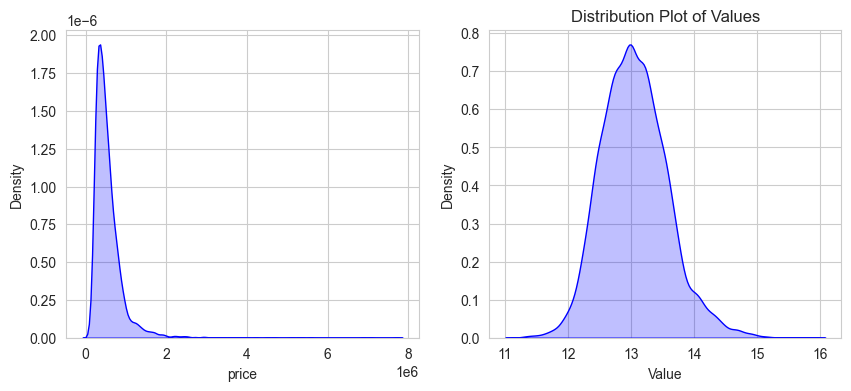

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # Change the figsize as needed
sns.set_style('whitegrid')  # Set the style of the plot
sns.kdeplot(df_training['price'], fill=True, color='blue',ax=axs[0])  # Create a kernel density plot
sns.kdeplot(np.log(df_training['price']), fill=True, color='blue',ax=axs[1])  # Create a kernel density plot

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Plot of Values')
plt.show()